In [113]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#tensorflow
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input

# others
from copy import deepcopy
from xgboost import XGBRegressor

# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES

In [2]:
# Split the stations by the number of samples available
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# # load datasets
# df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
# df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
# df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
# df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

In [15]:
df_load = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv")

# inner join with valid station (more than 300 stations)
threshold = 300
df_skn = df_load.groupby('skn').size().reset_index().rename(columns={0: "n_samples"})
df_skn_valid = df_skn[df_skn['n_samples'] > threshold]

df_data = df_load.merge(right=df_skn_valid, left_on='skn', right_on='skn')

In [16]:
# skn = df_data['skn'].sample().values[0]

# df_temp = df_data[df_data['year'] <= 2007]
# df_test = df_data[df_data['year'] > 2007]

# df_temp.sort_values(['year', 'month'], inplace=True)
# df_test.sort_values(['year', 'month'], inplace=True)

# Xtemp = np.array(df_temp[df_temp['skn'] == skn][columns])
# Ytemp = np.array(df_temp[df_temp['skn'] == skn]['data_in'])

# Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.2, shuffle=False)

# Xtest = np.array(df_test[df_test['skn'] == skn][columns])
# Ytest = np.array(df_test[df_test['skn'] == skn]['data_in'])

In [253]:
def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def define_model(num_inputs=20, lr=0.0065):
    inputs = Input(shape=(num_inputs,))
    x = Dense(units=20, activation='relu')(inputs)
    # x = Dense(units=16, activation='relu')(inputs)
    x = Dense(units=8, activation='relu')(x)
    x = Dense(units=4, activation='relu')(x)
    outputs = Dense(units=1, kernel_initializer='normal')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return model

# Try testing on a single station with simple single train/valid/test split

In [258]:
skn = df_data['skn'].sample().values[0]
print(f'{skn}')
df_station = df_data[df_data['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, shuffle=False)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.2, shuffle=False)

scaler = StandardScaler()

Xtrain = scaler.fit_transform(Xtrain)
Xvalid = scaler.transform(Xvalid)
Xtest = scaler.transform(Xtest)

1114.0


In [259]:
model = define_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, mode='min')
epochs=20

history = model.fit(
    Xtrain, Ytrain, 
    epochs=epochs, 
    validation_data = (Xvalid, Yvalid),
    callbacks=[callback],
    batch_size=64,
    verbose=0
)

yhat = model.predict(Xtest)
print(mean_squared_error(Ytest, yhat, squared=False))

2.6401822684077336


In [260]:
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
yhat = linear_regression.predict(Xtest)

print(mean_squared_error(Ytest, yhat, squared=False))

2.839487093427457


In [261]:

params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
xgboost = XGBRegressor(**params)

xgboost.fit(Xtrain, Ytrain)
yhat = xgboost.predict(Xtest)
print(mean_squared_error(Ytest, yhat, squared=False))

3.12209866513206


# Looks good. Now implement cross_val_predict for the NN model

In [314]:
def cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose):
    kf = KFold(n_splits=5)
    y_pred = []

    for train_index, test_index in kf.split(X):
        Xtemp, Xtest = X[train_index], X[test_index]
        Ytemp, Ytest = Y[train_index], Y[test_index]
        
        Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.2, shuffle=True)
        
        # scale the input
        scaler = StandardScaler()
        Xtrain = scaler.fit_transform(Xtrain)
        Xvalid = scaler.transform(Xvalid)
        Xtest = scaler.transform(Xtest)
        
        model.fit(
            Xtrain, Ytrain, epochs=epochs,
            validation_data = (Xvalid, Yvalid),
            callbacks=[callback],
            batch_size=batch_size,
            verbose=verbose
        )
        y_pred.extend(model.predict(Xtest).tolist())
    
    return np.array(y_pred)

In [315]:
skn = df_data['skn'].sample().values[0]
print(f'{skn}')
df_station = df_data[df_data['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

model = define_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
epochs=20
batch_size=64

yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
mean_squared_error(Y, yhat, squared=False)

2.0


2.271283341053673

In [316]:
yhat = cross_val_predict(LinearRegression(), X, Y, n_jobs=-1)
mean_squared_error(Y, yhat, squared=False)

2.1039270543980253

In [338]:
# try on ten random stations
list_df_results = []
n_samples = 100
skns = df_data['skn'].sample(n=n_samples).values
for i, skn in enumerate(skns):
    df_station = df_data[df_data['skn'] == skn]

    X = np.array(df_station[columns])
    Y = np.array(df_station['data_in'])

    model = define_model()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
    epochs=20
    batch_size=64

    yhat_nn = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
    rmse_nn = mean_squared_error(Y, yhat_nn, squared=False)
    
    yhat_lr = cross_val_predict(LinearRegression(), X, Y, n_jobs=-1)
    rmse_lr = mean_squared_error(Y, yhat_lr, squared=False)
    
    yhat_xgb = cross_val_predict(XGBRegressor(**params), X, Y, n_jobs=-1)
    rmse_xgb = mean_squared_error(Y, yhat_xgb, squared=False)
    
    list_df_results.append(
        pd.DataFrame({
            "skn": [skn] * df_station.shape[0],
            "data_in": Y,
            "pred_nn": yhat_nn.reshape(-1,),
            "pred_lr": yhat_lr,
            "pred_xgb": yhat_xgb
        })
    )
    #print(f"SKN: {skn}")
    #print("RMSE on NN : {:.3f}\nRMSE on LR : {:.3f}\nRMSE on XGB: {:.3f}".format(rmse_nn, rmse_lr, rmse_xgb))
    print(f"{i}/{n_samples}", end='\r')
df_results = pd.concat(list_df_results)

In [339]:
rmse_nn = mean_squared_error(df_results['data_in'], df_results['pred_nn'], squared=False)
rmse_lr = mean_squared_error(df_results['data_in'], df_results['pred_lr'], squared=False)
rmse_xgb = mean_squared_error(df_results['data_in'], df_results['pred_xgb'], squared=False)

rmse_nn, rmse_lr, rmse_xgb

(2.8175575736744447, 2.921170009258478, 3.1251328779876877)

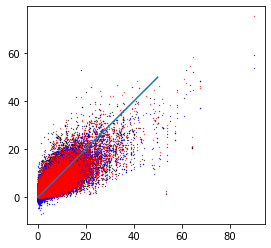

In [340]:
fig, ax = plt.subplots(1)
ax.scatter(df_results['data_in'], df_results['pred_xgb'], s=0.1, color='k')
ax.scatter(df_results['data_in'], df_results['pred_lr'], s=0.1, color='b')
ax.scatter(df_results['data_in'], df_results['pred_nn'], s=0.1, color='r')
ax.plot([0, 50], [0, 50])
ax.set_aspect('equal')